In [1]:
import pandas as pd
import numpy as np
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
from datetime import datetime, date, time, timezone
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import mglearn
from IPython.display import display

import glob
import os

# Dataset 3: FedEx orders with box dim

In [2]:
cols_list = ['Reference 2','Dim length', 'Dim width', 'Dim height']

files = glob.glob('/Users/elle.le/Workspace/BoxSize_local/new_data/FedEx_box/*.csv')

dfs =[]

for file in files:
    dfs.append(pd.read_csv(file, usecols = cols_list))

box_size = pd.concat(dfs, axis = 0, ignore_index = True, sort = False)
box_size.dropna(subset=['Dim height','Reference 2'], inplace = True)
box_size.rename(columns = {'Reference 2':'order_number'}, inplace = True)

box_size = box_size[['order_number','Dim length', 'Dim width', 'Dim height']]
box_size['box_vol']=box_size['Dim length']*box_size['Dim width']*box_size['Dim height']
print(box_size.shape)
box_size.head(5)

(578853, 5)


,order_number,Dim length,Dim width,Dim height,box_vol
0,791V-YVBD,11.0,8.0,6.0,528.0
1,YQ28-PKTY,15.0,10.0,4.0,600.0
2,1S2M-BKQM,10.0,15.0,6.0,900.0
3,XC5S-4MLT,10.0,7.0,4.0,280.0
4,KZJH-PQN2,11.0,8.0,6.0,528.0


In [3]:
box_size.isna().sum()

order_number    0
Dim length      0
Dim width       0
Dim height      0
box_vol         0
dtype: int64

In [4]:
# Sort 3 dim to create unique box profile
tmp_item = box_size.iloc[:,1:4].apply(sorted, axis=1)
tmp_item = pd.DataFrame(tmp_item.to_list(), columns=['dim1','dim2','dim3'])
box_size.iloc[:,1:4] = tmp_item.copy().to_numpy()

box_size.head(5)

,order_number,Dim length,Dim width,Dim height,box_vol
0,791V-YVBD,6.0,8.0,11.0,528.0
1,YQ28-PKTY,4.0,10.0,15.0,600.0
2,1S2M-BKQM,6.0,10.0,15.0,900.0
3,XC5S-4MLT,4.0,7.0,10.0,280.0
4,KZJH-PQN2,6.0,8.0,11.0,528.0


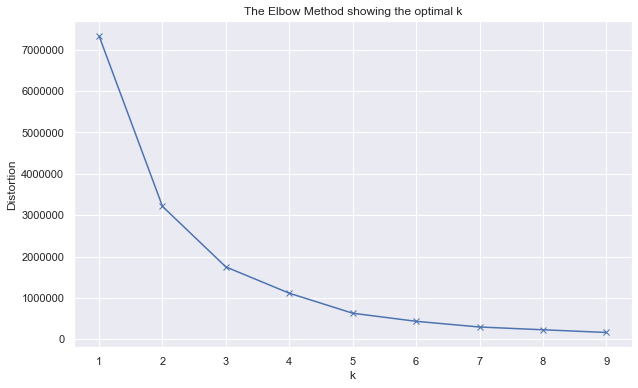

In [5]:
#K-means to decide number of box groups:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(box_size.iloc[:,1:4])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show() 

In [6]:
# Adding box type label for all orders
FedEx_box_type = 5
kmeans_box = KMeans(n_clusters=FedEx_box_type, random_state=0, max_iter = 1000).fit(box_size.iloc[:,1:4])
box_size['FedEx_box_type'] = kmeans_box.labels_
box_size.head(3)
box_label = box_size.drop(columns = ['Dim length','Dim width','Dim height','box_vol']).copy()
print(box_label.shape)
box_label.head(3)

(578853, 2)


,order_number,FedEx_box_type
0,791V-YVBD,3
1,YQ28-PKTY,1
2,1S2M-BKQM,1


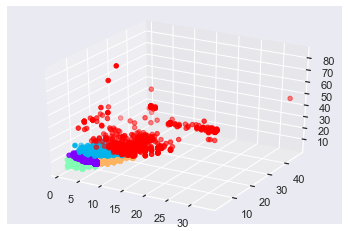

In [7]:
# Visualize the distribution of box label
cfig = plt.figure()
ax = cfig.add_subplot(111, projection='3d')
classes = kmeans_box.labels_
colors = cm.rainbow(np.linspace(0, 1, FedEx_box_type))
for i in range(FedEx_box_type):
    x=box_size.loc[classes == i, 'Dim length']
    y=box_size.loc[classes == i, 'Dim width']
    z=box_size.loc[classes == i, 'Dim height']
    ax.scatter(x, y,z,c=colors[i].reshape(1,-1))
   

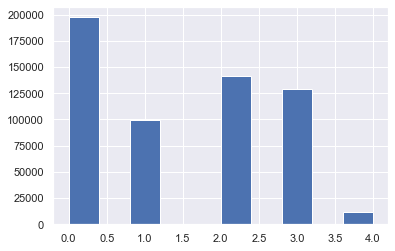

In [8]:
box_label['FedEx_box_type'].hist()

# Dataset 2: Order Line Item

In [9]:
line1 = pd.read_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/Jan2019_Jun2019_order_line.csv')
line2 = pd.read_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/Jul2019_Aug2020_order_line.csv')
line = pd.concat([line1,line2], ignore_index = True).copy()
line.shape

(6934053, 3)

In [10]:
line.head(3)

,order_number,variant_id,quantity
0,PV7B-Q92J,50404,1
1,PV7B-Q92J,57308,1
2,PV7B-Q92J,62133,1


In [11]:
sample_list = pd.read_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/sample_list.csv')
sample_list['indicator']=1
sample_list.head(4)

,variant_id,indicator
0,47348,1
1,47349,1
2,47640,1
3,47869,1


In [12]:
line_no_sample = pd.merge(line, sample_list, how = 'left', on ='variant_id')
line_no_sample.head(4)

,order_number,variant_id,quantity,indicator
0,PV7B-Q92J,50404,1,NaN
1,PV7B-Q92J,57308,1,NaN
2,PV7B-Q92J,62133,1,NaN
3,PV7B-Q92J,53174,1,NaN


In [13]:
line_no_sample = line_no_sample.loc[line_no_sample['indicator'] !=1].copy()

line_no_sample.drop(columns=['indicator'], inplace = True)

line_no_sample.shape

(4174316, 3)

In [14]:
line_no_sample.head(10)

,order_number,variant_id,quantity
0,PV7B-Q92J,50404,1
1,PV7B-Q92J,57308,1
2,PV7B-Q92J,62133,1
3,PV7B-Q92J,53174,1
4,PV7B-Q92J,57821,1
5,PV7B-Q92J,61632,1
6,PV7B-Q92J,59969,1
7,PV7B-Q92J,57810,1
10,291L-V7B7,62151,1
11,291L-V7B7,62157,1


In [15]:
# Finding list of total SKUs sold, with and without dimenstion

item=line_no_sample[['variant_id']].drop_duplicates()

item.shape

(14855, 1)

In [30]:
merge_dim = pd.merge(item,item_dim, how='left', on ='variant_id')

In [31]:
merge_dim = merge_dim.sort_values(['variant_id']).copy()

In [32]:
merge_dim.head(3)

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,item_vol,item_label
2470,126,18.0,18.0,172.0,3.34368,3.0
6141,127,18.0,18.0,172.0,3.34368,3.0
6468,128,18.0,18.0,172.0,3.34368,3.0


In [33]:
item_names = pd.read_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/all_item_names.csv')
print(item_names.shape)
item_names.head(4)

(15283, 7)


,variant_id,product_name,variant_name,name_string,brand_name,brand_id,weight
0,126,Perfect Brow Pencil,Taupe,anastasia-beverly-hills-perfect-brow-pencil-taupe,Anastasia Beverly Hills,117,0.03
1,127,Perfect Brow Pencil,Blonde,anastasia-beverly-hills-perfect-brow-pencil-bl...,Anastasia Beverly Hills,117,0.03
2,128,Perfect Brow Pencil,Caramel,anastasia-beverly-hills-perfect-brow-pencil-ca...,Anastasia Beverly Hills,117,0.03
3,129,Perfect Brow Pencil,Medium Brown,anastasia-beverly-hills-perfect-brow-pencil-me...,Anastasia Beverly Hills,117,0.03


In [34]:
all_item = pd.merge(merge_dim,item_names, how = 'left', on = 'variant_id')
all_item.head(3)

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,item_vol,item_label,product_name,variant_name,name_string,brand_name,brand_id,weight
0,126,18.0,18.0,172.0,3.34368,3.0,Perfect Brow Pencil,Taupe,anastasia-beverly-hills-perfect-brow-pencil-taupe,Anastasia Beverly Hills,117.0,0.03
1,127,18.0,18.0,172.0,3.34368,3.0,Perfect Brow Pencil,Blonde,anastasia-beverly-hills-perfect-brow-pencil-bl...,Anastasia Beverly Hills,117.0,0.03
2,128,18.0,18.0,172.0,3.34368,3.0,Perfect Brow Pencil,Caramel,anastasia-beverly-hills-perfect-brow-pencil-ca...,Anastasia Beverly Hills,117.0,0.03


In [ ]:
all_item.pd.to_csv(''/Users/elle.le/Workspace/BoxSize_local/new_data/all_item.csv')

In [66]:
brand = 'Jeffree Star Cosmetics'

In [67]:
conditions = all_item['product_name'].str.contains('Setting Powder', na=False) &  (all_item['brand_name'] == brand)

In [68]:
all_item.loc[conditions]

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,product_name,variant_name,name_string,brand_name,brand_id,weight
11389,64201,76.0,76.0,33.0,Magic Star Setting Powder,Banana,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
11390,64202,76.0,76.0,33.0,Magic Star Setting Powder,Beige,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
11391,64203,76.0,76.0,33.0,Magic Star Setting Powder,Caramel,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
11392,64204,76.0,76.0,33.0,Magic Star Setting Powder,Fair,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
11393,64205,76.0,76.0,33.0,Magic Star Setting Powder,Rose,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
11395,64207,76.0,76.0,33.0,Magic Star Setting Powder,Suede,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
11396,64208,76.0,76.0,33.0,Magic Star Setting Powder,Topaz,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
11401,64213,76.0,76.0,33.0,Magic Star Setting Powder,Translucent,jeffree-star-cosmetics-magic-star-setting-powd...,Jeffree Star Cosmetics,2944.0,0.17
14845,68799,NaN,NaN,NaN,Magic Star Luminous Setting Powder,Translucent,jeffree-star-cosmetics-magic-star-luminous-set...,Jeffree Star Cosmetics,2944.0,0.17
14846,68800,NaN,NaN,NaN,Magic Star Luminous Setting Powder,Natural,jeffree-star-cosmetics-magic-star-luminous-set...,Jeffree Star Cosmetics,2944.0,0.17


In [69]:
all_item['brand_name'].loc[all_item['dim_packaging_height_mm'].isna()].value_counts()

TOM FORD                 994
Inglot Cosmetics         729
Sisley-Paris             400
JILL STUART Beauty       238
Too Faced                160
                        ... 
Billy B                    1
Vintner's Daughter         1
Peter Thomas Roth          1
Zâ€¢Palette                1
Lucas' Papaw Remedies      1
Name: brand_name, Length: 102, dtype: int64

In [70]:
all_item.shape

(14855, 10)

# Dataset 1: Item 3D

In [17]:
cols = ['variant_id','dim_packaging_length_mm','dim_packaging_width_mm','dim_packaging_height_mm']
item_dim = pd.read_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/variant_specs.csv', usecols = cols)

In [18]:
item_dim.shape

(11920, 4)

In [38]:
item_dim.head(3)

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,item_vol,item_label
0,126,18.0,18.0,172.0,3.34368,3
1,127,18.0,18.0,172.0,3.34368,3
2,128,18.0,18.0,172.0,3.34368,3


In [20]:
item_dim.isna().sum()

variant_id                    0
dim_packaging_length_mm    1122
dim_packaging_width_mm     1122
dim_packaging_height_mm    1122
dtype: int64

In [21]:
item_dim.dropna(subset=['dim_packaging_length_mm'], inplace = True)

In [22]:
# Sort 3 dim to create unique item profile
tmp_item = item_dim.iloc[:,1:4].apply(sorted, axis=1)
tmp_item = pd.DataFrame(tmp_item.to_list(), columns=['dim1','dim2','dim3'])
item_dim.iloc[:,1:4] = tmp_item.copy().to_numpy()

In [23]:
# Add volume column in cubic inches:
item_dim['item_vol'] = item_dim['dim_packaging_length_mm']*item_dim['dim_packaging_width_mm']*item_dim['dim_packaging_height_mm']*6*1e-5

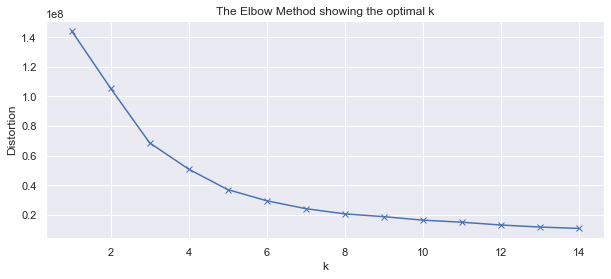

In [24]:
#elbow curve to find the optimal number of clusters. Answer = 4

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(item_dim.iloc[:,1:5])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(10,4))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()  

(4968,) (4968,) (4968,)
(1,) (1,) (1,)
(418,) (418,) (418,)
(5411,) (5411,) (5411,)


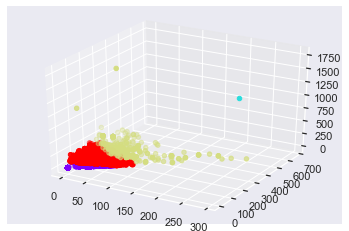

In [25]:
n_cluster = 4
kmeans = KMeans(n_clusters=n_cluster, random_state = 0,max_iter=2000).fit(item_dim.iloc[:,1:5])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
classes = kmeans.labels_
colors = cm.rainbow(np.linspace(0, 1, n_cluster))
for i in range(n_cluster):
    x=item_dim.loc[classes == i, 'dim_packaging_length_mm']
    y=item_dim.loc[classes == i, 'dim_packaging_width_mm']
    z=item_dim.loc[classes == i, 'dim_packaging_height_mm']
    print(x.shape,y.shape, z.shape)
    ax.scatter(x, y, z, c=colors[i].reshape(1,-1)) 

In [26]:
item_dim['item_label'] = kmeans.labels_
item_dim.sort_values(by=['item_label']).head(3)

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,item_vol,item_label
6032,59209,20.0,21.0,95.0,2.39400,0
7718,61815,18.0,21.0,87.0,1.97316,0
7719,61816,21.0,32.0,82.0,3.30624,0


In [27]:
item_dim.loc[item_dim['item_label']==1]

,variant_id,dim_packaging_length_mm,dim_packaging_width_mm,dim_packaging_height_mm,item_vol,item_label
7354,61245,191.0,673.0,795.0,6131.5011,1


In [28]:
item_dim['item_label'].value_counts()

3    5411
0    4968
2     418
1       1
Name: item_label, dtype: int64

In [39]:
#Ading max dimension of each item
item_label = item_dim[['variant_id','item_label','item_vol','dim_packaging_height_mm']].copy()
item_label.head(5)

,variant_id,item_label,item_vol,dim_packaging_height_mm
0,126,3,3.34368,172.0
1,127,3,3.34368,172.0
2,128,3,3.34368,172.0
3,129,3,3.34368,172.0
4,130,3,3.34368,172.0


# Merge 3 datasets to create a feature matrix

In [40]:
line_no_sample.head(3)

,order_number,variant_id,quantity
0,PV7B-Q92J,50404,1
1,PV7B-Q92J,57308,1
2,PV7B-Q92J,62133,1


In [41]:
box_label.head(3)

,order_number,FedEx_box_type
0,791V-YVBD,3
1,YQ28-PKTY,1
2,1S2M-BKQM,1


In [42]:
item_label.head(3)

,variant_id,item_label,item_vol,dim_packaging_height_mm
0,126,3,3.34368,172.0
1,127,3,3.34368,172.0
2,128,3,3.34368,172.0


In [43]:
order_line_vol=pd.merge(line_no_sample,item_label, how='left', on = 'variant_id').dropna(subset = ['item_label'])
order_line_vol.head(2)

,order_number,variant_id,quantity,item_label,item_vol,dim_packaging_height_mm
0,PV7B-Q92J,50404,1,0.0,2.39400,95.0
1,PV7B-Q92J,57308,1,2.0,175.53456,358.0


In [44]:
order_line_vol.shape

(3869866, 6)

In [45]:
order_line_vol['order_number'].nunique()

949151

In [46]:
final1=pd.merge(order_line_vol,box_label, how='left', on='order_number').dropna(subset = ['FedEx_box_type'])

In [47]:
final1.head(10)

,order_number,variant_id,quantity,item_label,item_vol,dim_packaging_height_mm,FedEx_box_type
0,PV7B-Q92J,50404,1,0.0,2.39400,95.0,1.0
1,PV7B-Q92J,57308,1,2.0,175.53456,358.0,1.0
2,PV7B-Q92J,62133,1,0.0,2.39400,95.0,1.0
3,PV7B-Q92J,53174,1,3.0,2.81088,183.0,1.0
4,PV7B-Q92J,57821,1,3.0,19.11420,185.0,1.0
5,PV7B-Q92J,61632,1,3.0,19.11420,185.0,1.0
6,PV7B-Q92J,59969,1,3.0,13.00500,150.0,1.0
7,PV7B-Q92J,57810,1,0.0,1.97316,87.0,1.0
8,91DK-BBVY,61548,1,0.0,2.40408,54.0,2.0
11,CNPK-D5LL,60103,1,0.0,0.00000,0.0,0.0


In [48]:
final1['order_number'].nunique()

526877

In [49]:
box_label.shape

(578853, 2)

In [50]:
# Calculate total order volume:

item_matrix_1 = pd.pivot_table(final1,
              index = ['order_number'],
              values = ['item_vol'],
              fill_value = 0,
              aggfunc ={ 'item_vol':sum} )

item_matrix_1.columns = ['total_order_vol']
item_matrix_1.reset_index(level=0, inplace=True)
item_matrix_1

,order_number,total_order_vol
0,1111-J5BD,19.86888
1,1114-T3BD,62.73960
2,1116-5YL5,27.73848
3,1116-7HL5,122.90136
4,1116-7ZBT,8.31762
...,...,...
526872,ZZYH-RBZ4,17.94372
526873,ZZYN-RBV4,28.57860
526874,ZZYR-QBB6,459.86904
526875,ZZYR-XGB6,531.14112


In [62]:
# Matrix with item type only
item_matrix_2 = pd.pivot_table(final1,
              index = ['order_number'],
              values = ['quantity','dim_packaging_height_mm'],
              columns = ['item_label'],
              aggfunc ={'quantity':sum,'dim_packaging_height_mm':np.amax },                 
              fill_value = 0)

item_matrix_2.columns = ['d1','d2','d3','d4','item_size_0','item_size_1','item_size_2','item_size_3']
item_matrix_2['max_item_dim'] = item_matrix_2[['d1','d2','d3','d4']].max(axis=1)
item_matrix_2.drop(columns=['d1','d2','d3','d4'],inplace = True)
item_matrix_2.reset_index(level=0, inplace=True)
item_matrix_2

,order_number,item_size_0,item_size_1,item_size_2,item_size_3,max_item_dim
0,1111-J5BD,3,0,0,0,76
1,1114-T3BD,0,0,1,0,245
2,1116-5YL5,1,0,0,1,260
3,1116-7HL5,1,0,0,10,214
4,1116-7ZBT,0,0,0,2,175
...,...,...,...,...,...,...
526872,ZZYH-RBZ4,6,0,0,2,142
526873,ZZYN-RBV4,8,0,0,4,142
526874,ZZYR-QBB6,6,0,2,0,322
526875,ZZYR-XGB6,4,0,2,2,358


In [63]:
item_matrix = pd.merge(item_matrix_2,item_matrix_1, how = 'left', on ='order_number')
item_matrix

,order_number,item_size_0,item_size_1,item_size_2,item_size_3,max_item_dim,total_order_vol
0,1111-J5BD,3,0,0,0,76,19.86888
1,1114-T3BD,0,0,1,0,245,62.73960
2,1116-5YL5,1,0,0,1,260,27.73848
3,1116-7HL5,1,0,0,10,214,122.90136
4,1116-7ZBT,0,0,0,2,175,8.31762
...,...,...,...,...,...,...,...
526872,ZZYH-RBZ4,6,0,0,2,142,17.94372
526873,ZZYN-RBV4,8,0,0,4,142,28.57860
526874,ZZYR-QBB6,6,0,2,0,322,459.86904
526875,ZZYR-XGB6,4,0,2,2,358,531.14112


In [64]:
final_matrix = pd.merge(item_matrix,box_label, how ='left', on='order_number')
final_matrix

,order_number,item_size_0,item_size_1,item_size_2,item_size_3,max_item_dim,total_order_vol,FedEx_box_type
0,1111-J5BD,3,0,0,0,76,19.86888,0
1,1114-T3BD,0,0,1,0,245,62.73960,1
2,1116-5YL5,1,0,0,1,260,27.73848,3
3,1116-7HL5,1,0,0,10,214,122.90136,1
4,1116-7ZBT,0,0,0,2,175,8.31762,0
...,...,...,...,...,...,...,...,...
528412,ZZYH-RBZ4,6,0,0,2,142,17.94372,2
528413,ZZYN-RBV4,8,0,0,4,142,28.57860,0
528414,ZZYR-QBB6,6,0,2,0,322,459.86904,3
528415,ZZYR-XGB6,4,0,2,2,358,531.14112,1


In [65]:
final_matrix.to_csv('/Users/elle.le/Workspace/BoxSize_local/new_data/box_size_cleaned_data.csv', index=False)